<a href="https://colab.research.google.com/github/NikolaZubic/AppliedGameTheoryHomeworkSolutions/blob/main/domaci8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OSMI DOMAĆI ZADATAK iz predmeta "Primenjena teorija igara" (Applied Game Theory)

a) Simulacija diferencijalne igre sa N letjelica koristeći prioritet<br>
b) Simulacija diferencijalne igre sa N letjelica koristeći funkciju nesreće

Implementirano po uzoru na [link](https://github.com/aalu1418/differential-games).

# Potrebni import-i i konstante

In [ ]:
from math import sqrt
import matplotlib.pyplot as plt

# CONSTANTS
DISTANCE_COLLISION = 20  # a)
DETECTION_RADIUS = 140   # b)

COLOURS = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # to represent aircrafts on plot
###########

# Definisanje klase koja enkapsulira osnovne informacije o svakom agentu (letjelici) u ovoj diferencijalnoj igri

In [ ]:
class AgentInfo(object):
    """
    Encapsulates main information about every agent regarding its goal, initial position, history of taken positions
    during the differential game, maximum velocity and id.
    """
    def __init__(self, goal, initial_position, maximum_velocity, identifier):
        self.goal = goal
        self.initial_position = initial_position
        # after assigning initial position, make it as position_0 in position's history
        self.positions_history = [self.initial_position]
        self.maximum_velocity = maximum_velocity
        self.identifier = identifier

# Definisanje agenta za a)

In [ ]:
class SimpleAgent(object):
    def __init__(self, agent_info):
        self.agent_info = agent_info

    @property
    def get_current_position(self):
        return self.agent_info.positions_history[-1]  # get the last element in collection

    @property
    def get_aircraft_index(self):
        return self.agent_info.identifier

    def collision_region_detected(self, j, collision_distance):
        """
        :param j: other aircraft
        :param collision_distance: d_c
        :return: whether we have detected another aircraft in collision region
        """
        current_x, current_y = self.get_current_position[0], self.get_current_position[1]  # aircraft that we analyze
        x_j, y_j = j

        norm = sqrt(pow(x_j - current_x, 2) + pow(y_j - current_y, 2))

        return norm < collision_distance  # inside the region, STRICTLY less

    def priority_policy(self, aircrafts):
        """
        We assign a priority to all aircrafts whereat the lower indexes are aircrafts of higher priorities.
        [x0, ... , xN] means that x0 has HIGHER priority than x1, ... , x(N-1) has HIGHER priority than xN.

        :param aircrafts: all aircrafts in differential game
        :return: updated position by going with either maximum velocity or 0 in other case
        """
        current_aircraft_id = self.get_aircraft_index

        # take all aircrafts that have HIGHER priority than the current one (that we analyze)
        for i in range(0, current_aircraft_id):
            if self.collision_region_detected(aircrafts[i].get_current_position, DISTANCE_COLLISION):
                # If an agent is in the collision region with an aircraft of higher priority, don't move him
                return None

        current_x, current_y = self.get_current_position[0], self.get_current_position[1]
        goal_x, goal_y = self.agent_info.goal[0], self.agent_info.goal[1]

        distance_from_goal_x, distance_from_goal_y = goal_x - current_x, goal_y - current_y
        norm = sqrt(pow(distance_from_goal_x, 2) + pow(distance_from_goal_y, 2))

        if norm != 0:
            move_vector_x, move_vector_y = distance_from_goal_x / norm, distance_from_goal_y / norm
        else:
            move_vector_x, move_vector_y = 0, 0

        # take all aircrafts that have LOWER priority than the current one (that we analyze)
        for i in range(current_aircraft_id + 1, len(aircrafts)):
            """
            If an agent is in the collision region with an aircraft of lower priority, then it is expected that he 'll
            move with maximum velocity and the aircraft with lower priority won't move.
            """
            if self.collision_region_detected(aircrafts[i].get_current_position, DISTANCE_COLLISION):
                update_position_x = current_x + self.agent_info.maximum_velocity * move_vector_x
                update_position_y = current_y + self.agent_info.maximum_velocity * move_vector_y

                return update_position_x, update_position_y

        update_x = current_x + self.agent_info.maximum_velocity * move_vector_x
        update_y = current_y + self.agent_info.maximum_velocity * move_vector_y

        return update_x, update_y


# Definisanje unaprijeđenog agenta za b)

In [ ]:
class ImprovedAgent(object):
    def __init__(self, agent_info):
        self.agent_info = agent_info

    @property
    def get_current_position(self):
        return self.agent_info.positions_history[-1]  # get the last element in collection

    @property
    def get_aircraft_index(self):
        return self.agent_info.identifier

    def collision_region_detected(self, j, collision_distance):
        """
        :param j: other aircraft
        :param collision_distance: d_c
        :return: whether we have detected another aircraft in collision region
        """
        current_x, current_y = self.get_current_position[0], self.get_current_position[1]  # aircraft that we analyze
        x_j, y_j = j

        norm = sqrt(pow(x_j - current_x, 2) + pow(y_j - current_y, 2))

        return norm < collision_distance  # inside the region, STRICTLY less

    def degree_of_accident_policy(self, aircrafts):
        """
        Here, we implement new policy where we have some detection radius R for each aircraft. Additionally, we use
        function called degree of accident V that is defined as following for i-th aircraft:
        V_i(x_1, x_2, ... , x_N) = (1/2) * (||x_i - z_i||)^2 + (1/2) *
        sum[for j != i]( max( (R^2 - ||x_i - x_j||^2) / (||x_i - x_j||^2 - r^2) , 0) )^2 ,

        where x_i is current position of i-th aircraft, x_j is current position of j-th aircraft in j-th iteration
        through sum, z_i is the goal of i-th aircraft.

        This helps us to detect collision region between aircrafts only if they are inside detection radius, otherwise
        we won't take them into account. Maximum function inside sum will produce big number if aircrafts are INSIDE
        (strictly less) collision region, which will lead to upsurge of V.

        :param aircrafts: all aircrafts in differential game
        :return: updated position based on V function
        """

        # v_i = z_i - x_i + sum[j]( a_ij * (x_i - x_j) )

        a_i, a_j = 0, 0
        current_x, current_y = self.get_current_position[0], self.get_current_position[1]

        for aircraft in aircrafts:
            if aircraft.get_aircraft_index != self.get_aircraft_index:
                # analyze all the other aircrafts from the viewpoint of current aircraft
                x_j, y_j = aircraft.get_current_position[0], aircraft.get_current_position[1]

                distance_ij_X, distance_ij_Y = x_j - current_x, y_j - current_y

                norm = sqrt(pow(distance_ij_X, 2) + pow(distance_ij_Y, 2))

                # max( (R^2 - ||x_i - x_j||^2) / (||x_i - x_j||^2 - r^2) , 0)
                max_function = max(
                    (pow(DETECTION_RADIUS, 2) - pow(norm, 2)) / (pow(norm, 2) - pow(DISTANCE_COLLISION, 2)), 0)

                a_i, a_j = a_i + distance_ij_X * max_function, a_j + distance_ij_Y * max_function

        goal_x, goal_y = self.agent_info.goal[0], self.agent_info.goal[1]

        distance_from_goal_x, distance_from_goal_y = goal_x - current_x, goal_y - current_y

        z_minus_x_i, z_minus_x_j = distance_from_goal_x - a_i, distance_from_goal_y - a_j
        norm = sqrt(pow(z_minus_x_i, 2) + pow(z_minus_x_j, 2))

        move_vector_x, move_vector_y = z_minus_x_i / norm, z_minus_x_j / norm

        update_x = current_x + self.agent_info.maximum_velocity * move_vector_x
        update_y = current_y + self.agent_info.maximum_velocity * move_vector_y

        return update_x, update_y


# Definisanje klase zadužene za simulaciju

In [ ]:
class Simulation(object):
    def __init__(self, aircrafts):
        self.aircrafts = aircrafts

    def run(self):
        for i in range(200):
            for aircraft in self.aircrafts:
                if isinstance(aircraft, SimpleAgent):
                    position = aircraft.priority_policy(aircrafts=aircrafts)

                    if position is not None:
                        aircraft.agent_info.positions_history.append(position)

                elif isinstance(aircraft, ImprovedAgent):
                    position = aircraft.degree_of_accident_policy(aircrafts=aircrafts)

                    if position is not None:
                        aircraft.agent_info.positions_history.append(position)

    def draw(self):
        plt.xlim(-205, 205)
        plt.ylim(-155, 155)
        plt.xlabel('x', fontsize=18)
        plt.ylabel('y', fontsize=18)

        i = 0

        for aircraft in self.aircrafts:
            x, y = [], []
            for position in aircraft.agent_info.positions_history:
                x.append(position[0])
                y.append(position[1])

            plt.plot(x, y, "{}".format(COLOURS[i]), linestyle="dotted")

            plt.plot(aircraft.agent_info.initial_position[0], aircraft.agent_info.initial_position[1],
                     "{}o".format(COLOURS[i]), markersize=9)

            plt.plot(aircraft.agent_info.goal[0], aircraft.agent_info.goal[1],
                     "{}x".format(COLOURS[i]), markersize=9)

            i += 1

        plt.show()

    @staticmethod
    def run_simulation(agents):
        simulation = Simulation(agents)
        simulation.run()
        simulation.draw()


# Glavni program (pokretanje simulacije)

Running simulation a)


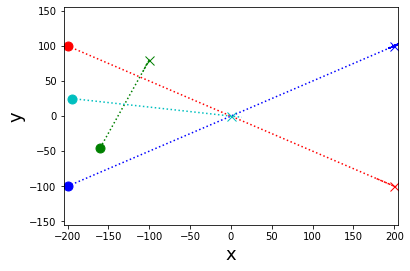

Running simulation b)


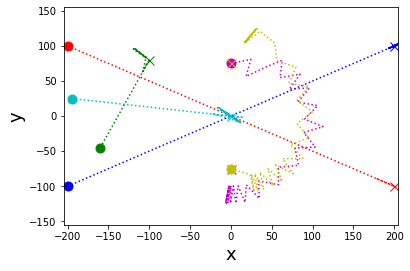

Running simulation b) #2


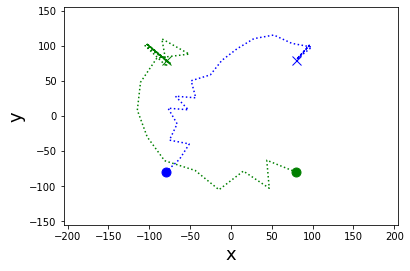

In [ ]:
if __name__ == "__main__":
    aircrafts_info = [
        AgentInfo(goal=(200, 100), initial_position=(-200, -100), maximum_velocity=40, identifier=0),
        AgentInfo(goal=(-100, 80), initial_position=(-160, -45), maximum_velocity=20, identifier=1),
        AgentInfo(goal=(200, -100), initial_position=(-200, 100), maximum_velocity=30, identifier=2),
        AgentInfo(goal=(0, 0), initial_position=(-195, 25), maximum_velocity=35, identifier=3),
        AgentInfo(goal=(0, -75), initial_position=(0, 75), maximum_velocity=25, identifier=4),
        AgentInfo(goal=(0, 75), initial_position=(0, -75), maximum_velocity=25, identifier=5),
    ]

    aircrafts = [SimpleAgent(aircrafts_info[i]) for i in range(len(aircrafts_info) - 2)]
    improved_aircrafts = [ImprovedAgent(aircrafts_info[i]) for i in range(len(aircrafts_info))]

    print("Running simulation a)")
    Simulation.run_simulation(aircrafts)
    print("Running simulation b)")
    Simulation.run_simulation(improved_aircrafts)

    aircrafts_info = [
        AgentInfo(goal=(80, 80), initial_position=(-80, -80), maximum_velocity=25, identifier=0),
        AgentInfo(goal=(-80, 80), initial_position=(80, -80), maximum_velocity=40, identifier=1)
    ]
    improved_aircrafts = [ImprovedAgent(aircrafts_info[i]) for i in range(len(aircrafts_info))]
    print("Running simulation b) #2")
    Simulation.run_simulation(improved_aircrafts)
